## <b> Capstone Project: Predicting future electricity stock market prices <b>

    
## Table of contents
* [1. Introduction: Business Problem](#introduction)
* [2. Data](#data)
* [3. Methodology](#methodology)
* [4. Analysis](#analysis)
* [5. Results and Discussion](#results)


## 1. Introduction: Business Problem <a name="introduction"></a>

In Germany electricity consumers with very high demand, like big industrial plants, or electricity producer deal their electricity, in contrast to private people, on the stock exchange for electricity exchange (EPEX, European Power Exchange). The most interesting stock exchange for electricity is the Day Ahead Market, where the electricity is marketed for the following day. That is why, the profitability of such business models can be increased if one has a reliable forecast of exchange electricity prices for the next day.

That's where our Data Science skills are needed. In the context of this work we try to find out, if we can explain the current electricity price in dependence of the current electricity demand and production in Germany.
In a further step we also try to forecast the stock market prices for the next 24h. Since the forecasts for the production and demand are quite accurate, we take the future production and demand as given and use them for our prediction.

## 2. Data <a name="data"></a>

### 2.1 Data Sources

All data we need we find at the web portal SMARD from the Germanys Federal Network Agency (https://www.smard.de). In regard to our business problem, we need following data for our analysis: electricity stock market prices, electricity demand and production. We can download these data for the period from 2016 until now via the link below. Notice that the demand and production have a resolution of 15 minutes and the prices of 1 hour.


(https://www.smard.de/home/downloadcenter/download_marktdaten/726#!?downloadAttributes=%7B%22selectedCategory%22:5,%22selectedSubCategory%22:17,%22selectedRegion%22:%22DE%22,%22from%22:1514761200000,%22to%22:1546297199999,%22selectedFileType%22:%22CSV%22%7D)


### 2.2 Load Data

First we install and import necessary libaries for the ETL process:


In [0]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style
import seaborn as sns

import datetime

import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Next we load the data from the disk, merge the data and transfer them into pandas DataFrames.

In [52]:
elec_prices=pd.read_csv('Gro_handelspreise_201601010000_201712312359_1.csv', header=0, sep=';').append(pd.read_csv('Gro_handelspreise_201801010000_201812312359_1.csv', header=0, sep=';').append(pd.read_csv('Gro_handelspreise_201901010000_202005292359_1.csv', header=0, sep=';'))).reset_index(drop=True)
elec_demand=pd.read_csv('Realisierter_Stromverbrauch_201601010000_201712312345_1.csv', header=0, sep=';').append(pd.read_csv('Realisierter_Stromverbrauch_201801010000_201812312359_1.csv', header=0, sep=';').append(pd.read_csv('Realisierter_Stromverbrauch_201901010000_202005292345_1.csv', header=0,sep=';'))).reset_index(drop=True)
elec_supply=pd.read_csv('Realisierte_Erzeugung_201601010000_201712312345_1.csv', header=0, sep=';').append(pd.read_csv('Realisierte_Erzeugung_201801010000_201812312359_1.csv', header=0, sep=';').append(pd.read_csv('Realisierte_Erzeugung_201901010000_202005292345_1.csv', header=0, sep=';'))).reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



### 2.2 Data Exploration, Cleaning and Wrangling


Data quality:
As expected for a federal agency dataset the quality is perfect and there are no missing or wrong values.

Cause the market area in Germany changed in the inspected time, we have to merge the columns 'Deutschland/Luxemburg[€/MWh]' and 'Deutschland/Österreich/Luxemburg[€/MWh]' to only one price column. This and some other data wrangling tasks and the merge of all data into one DataFrame we solve in the next lines:

In [0]:
# New Datetime Column
elec_supply['Datetime']=pd.date_range(start='01/01/2016 00:00:00', end='05/29/2020 23:45:00', freq='15Min')
elec_demand['Datetime']=pd.date_range(start='01/01/2016 00:00:00', end='05/29/2020 23:45:00', freq='15Min')
elec_prices['Datetime']=pd.date_range(start='01/01/2016 00:00:00', end='05/29/2020 23:45:00', freq='60Min')

# delete old Date Column
elec_supply.drop(columns=['Datum', 'Uhrzeit'],inplace =True)
elec_demand.drop(columns=['Datum', 'Uhrzeit'],inplace =True)
elec_prices.drop(columns=['Datum', 'Uhrzeit'],inplace =True)

# Rearange the Columns 
elec_supply_col_names=['Datetime','Biomasse[MWh]', 'Wasserkraft[MWh]', 'Wind Offshore[MWh]',
        'Wind Onshore[MWh]', 'Photovoltaik[MWh]', 'Sonstige Erneuerbare[MWh]',
        'Kernenergie[MWh]', 'Braunkohle[MWh]', 'Steinkohle[MWh]', 'Erdgas[MWh]',
        'Pumpspeicher[MWh]', 'Sonstige Konventionelle[MWh]']
elec_demand_col_names=['Datetime','Gesamt[MWh]']
elec_prices_col_names=['Datetime','Deutschland/Luxemburg[€/MWh]','Deutschland/Österreich/Luxemburg[€/MWh]']

elec_supply=elec_supply[elec_supply_col_names]
elec_demand=elec_demand[elec_demand_col_names]
elec_prices=elec_prices[elec_prices_col_names]


# Wrangling the elec_prices dataframe 
elec_prices.replace("-", "0", inplace = True)
#for i in range(1,len(elec_prices_col_names)):
 #   elec_prices[elec_prices_col_names[i]] = [x.replace(".", "") for x in elec_prices[elec_prices_col_names[i]]]
  #  elec_prices[elec_prices_col_names[i]] = [x.replace(",", ".") for x in elec_prices[elec_prices_col_names[i]]]

elec_supply.replace("-", "0", inplace = True)
#for i in range(1,len(elec_supply_col_names)):
 #   elec_supply[elec_supply_col_names[i]] = [str(x).replace(".", "") for x in elec_supply[elec_supply_col_names[i]]]
  #  elec_supply[elec_supply_col_names[i]] = [str(x).replace(",", ".") for x in elec_supply[elec_supply_col_names[i]]]

elec_demand.replace("-", "0", inplace = True)
#for i in range(1,len(elec_demand_col_names)):
 #   elec_demand[elec_demand_col_names[i]] = [str(x).replace(".", "") for x in elec_demand[elec_demand_col_names[i]]]
  #  elec_demand[elec_demand_col_names[i]] = [str(x).replace(",", ".") for x in elec_demand[elec_demand_col_names[i]]]
    
# Convert to float
elec_supply[elec_supply_col_names[1:]]=elec_supply[elec_supply_col_names[1:]].astype('float')
elec_demand[elec_demand_col_names[1:]]=elec_demand[elec_demand_col_names[1:]].astype('float')
elec_prices[elec_prices_col_names[1:]]=elec_prices[elec_prices_col_names[1:]].astype('float')

# Cause the market area in Germany changed in the inspected time, we introduce one only price column 
elec_prices['price[€/MWh]']=elec_prices[elec_prices_col_names[1:]].sum(axis=1)
elec_prices.drop(columns=['Deutschland/Luxemburg[€/MWh]','Deutschland/Österreich/Luxemburg[€/MWh]'],inplace =True)


# Reduce resolution of dataframes from 15min to 60min, so that it fits to the price dataframe
a=[]
[a.append(tm - datetime.timedelta(minutes=tm.minute % 60)) for x,tm in enumerate(elec_supply.iloc[:,0])] 
elec_supply['Datetime']=a
elec_demand['Datetime']=a

elec_supply=elec_supply.groupby('Datetime').sum().reset_index()
elec_demand=elec_demand.groupby('Datetime').sum().reset_index()

# Merge the supply anf demand dataframes
elec_sdp = elec_supply.join(elec_demand.set_index('Datetime'), on='Datetime')
#Feature Engineering
#elec_sdp['Import/Export[MWh]']=elec_sdp.iloc[:,1:-2].sum(axis=1)-elec_sdp['Gesamt[MWh]']

# Merge with the price dataframe
elec_sdp=elec_sdp.join(elec_prices.set_index('Datetime'), on='Datetime')

# Next we have to delete the column "Pumpspeicher" ("Pump storage"), cause we suppose that we only can predict the amount of renewable energies in the grid.
elec_sdp.drop(columns=['Pumpspeicher[MWh]'],inplace =True)


Here we can take a look into the merged dataset:

In [54]:
elec_sdp.head()

,Datetime,Biomasse[MWh],Wasserkraft[MWh],Wind Offshore[MWh],Wind Onshore[MWh],Photovoltaik[MWh],Sonstige Erneuerbare[MWh],Kernenergie[MWh],Braunkohle[MWh],Steinkohle[MWh],Erdgas[MWh],Sonstige Konventionelle[MWh],Gesamt[MWh],price[€/MWh]
0,2016-01-01 00:00:00,4666.0,1038.0,2276.0,6372.0,0.0,176.0,10706.0,14720.0,4849.0,1931.0,3289.0,41905.0,23.86
1,2016-01-01 01:00:00,4660.0,1032.0,2287.0,6294.0,0.0,176.0,10702.0,14793.0,4128.0,1935.0,3201.0,40127.0,22.39
2,2016-01-01 02:00:00,4651.0,1029.0,2229.0,6313.0,0.0,176.0,10604.0,14856.0,3884.0,1935.0,2952.0,38429.0,20.59
3,2016-01-01 03:00:00,4657.0,1017.0,2011.0,6430.0,0.0,176.0,10684.0,14954.0,3670.0,1925.0,2823.0,37485.0,16.81
4,2016-01-01 04:00:00,4641.0,998.0,1944.0,6352.0,0.0,176.0,10608.0,14931.0,3657.0,1943.0,2598.0,37150.0,17.41


In [55]:
elec_sdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38664 entries, 0 to 38663
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Datetime                      38664 non-null  datetime64[ns]
 1   Biomasse[MWh]                 38664 non-null  float64       
 2   Wasserkraft[MWh]              38664 non-null  float64       
 3   Wind Offshore[MWh]            38664 non-null  float64       
 4   Wind Onshore[MWh]             38664 non-null  float64       
 5   Photovoltaik[MWh]             38664 non-null  float64       
 6   Sonstige Erneuerbare[MWh]     38664 non-null  float64       
 7   Kernenergie[MWh]              38664 non-null  float64       
 8   Braunkohle[MWh]               38664 non-null  float64       
 9   Steinkohle[MWh]               38664 non-null  float64       
 10  Erdgas[MWh]                   38664 non-null  float64       
 11  Sonstige Konventionelle[MWh]

In [56]:
elec_sdp.describe()

,Biomasse[MWh],Wasserkraft[MWh],Wind Offshore[MWh],Wind Onshore[MWh],Photovoltaik[MWh],Sonstige Erneuerbare[MWh],Kernenergie[MWh],Braunkohle[MWh],Steinkohle[MWh],Erdgas[MWh],Sonstige Konventionelle[MWh],Gesamt[MWh],price[€/MWh]
count,38664.000000,38664.00000,38664.000000,38664.000000,38664.000000,38664.000000,38664.000000,38664.000000,38664.000000,38664.000000,38664.000000,38664.000000,38664.000000
mean,4608.586521,1828.10394,2189.122924,10148.058950,4445.408649,161.088222,8271.088519,13390.349919,7191.289054,4353.215937,2969.509647,56016.250854,35.089916
std,302.005603,406.50955,1591.956677,8305.153169,6871.460769,33.595066,1466.460544,3515.534232,4512.814155,2501.569410,2416.167631,10004.271728,17.285624
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31307.000000,-130.090000
25%,4437.000000,1535.25000,757.500000,3803.187500,0.000000,135.000000,7370.812500,11801.000000,3090.000000,2368.000000,1129.000000,47629.000000,26.010000
50%,4658.000000,1790.75000,2007.500000,7681.000000,117.000000,158.000000,8413.750000,14542.000000,6426.000000,3724.000000,1411.000000,55578.000000,34.740000
75%,4801.750000,2080.75000,3372.000000,14095.625000,6965.125000,184.000000,9308.750000,15849.000000,10665.250000,5932.000000,4658.250000,64866.500000,44.382500
max,5114.000000,3139.00000,6901.000000,40753.000000,32674.000000,244.000000,10800.000000,19169.000000,19143.000000,14475.000000,19933.000000,77549.000000,163.520000


Let's do some data visualization to get more familiar with the data set.
First we make a bar chart to visualize the energy generation per year. Therefore, we have to normalize our dataset to one year. 

In [57]:
# First we need the number of days of our dataset: 880 days
elec_sdp['Datetime'].max()-elec_sdp['Datetime'].min()

Timedelta('1610 days 23:00:00')

In [0]:
# Normalization and convert  from MWh to TWh
elec_supply_peryear=elec_sdp.iloc[:,1:-2].sum()/1000000/880*365

Here you can see the energy generation for each producer type for one  year:

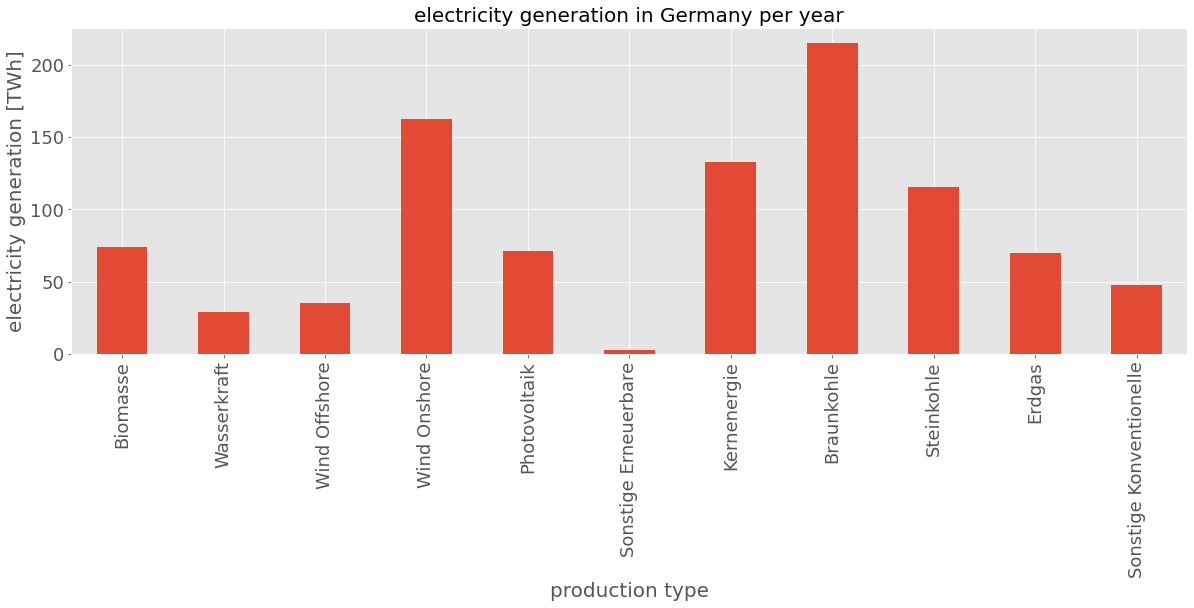

In [81]:
elec_supply_peryear.index=['Biomasse', 'Wasserkraft', 'Wind Offshore',
       'Wind Onshore', 'Photovoltaik', 'Sonstige Erneuerbare',
       'Kernenergie', 'Braunkohle', 'Steinkohle', 'Erdgas',
       'Sonstige Konventionelle']

elec_supply_peryear.plot(kind='bar', figsize=(20, 6), rot=90,fontsize=18) 

plt.xlabel('production type', fontsize=20)
plt.ylabel('electricity generation [TWh]', fontsize=20)
plt.title('electricity generation in Germany per year', fontsize=20)

plt.show()

Now let's check how high is the amount of renewable energy:

In [60]:
elec_supply_RE_Konv_peryear=[elec_supply_peryear[0:6].sum(),elec_supply_peryear[6:].sum()]
elec_supply_RE_Konv_peryear/elec_supply_peryear.sum()
#elec_supply_RE_Konv_peryear=pd.DataFrame({"renewable energy": [elec_supply_RE_Konv_peryear[0]],"fossil energy": [elec_supply_RE_Konv_peryear[1]]})

array([0.39257907, 0.60742093])

So more than 40% of the generated energy in Germany is from renewable energy sources. Hopefully it becomes more and more.

Since the price column is our label, we visualize it:

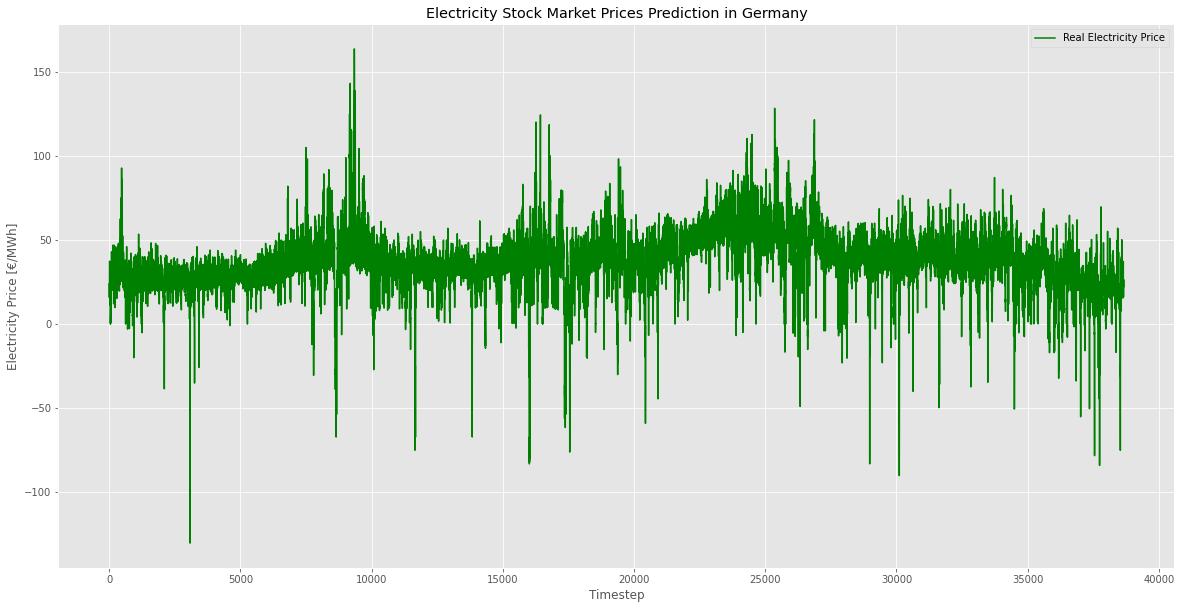

In [86]:
plt.figure(figsize=(20,10))
plt.plot(elec_sdp['price[€/MWh]'], color = 'green', label = 'Real Electricity Price')
plt.title('Electricity Stock Market Prices Prediction in Germany')
plt.xlabel('Timestep')
plt.ylabel('Electricity Price [€/MWh]')
plt.legend()
plt.show()

Next we investigate the distriution of the prices by creating a histogram:

[    1     0     1     4    38    38    32    26    54    95   374  1657
  4559 12083 11290  5521  1810   729   222    67    33    19     5     4
     2]
[-130.09   -118.3456 -106.6012  -94.8568  -83.1124  -71.368   -59.6236
  -47.8792  -36.1348  -24.3904  -12.646    -0.9016   10.8428   22.5872
   34.3316   46.076    57.8204   69.5648   81.3092   93.0536  104.798
  116.5424  128.2868  140.0312  151.7756  163.52  ]


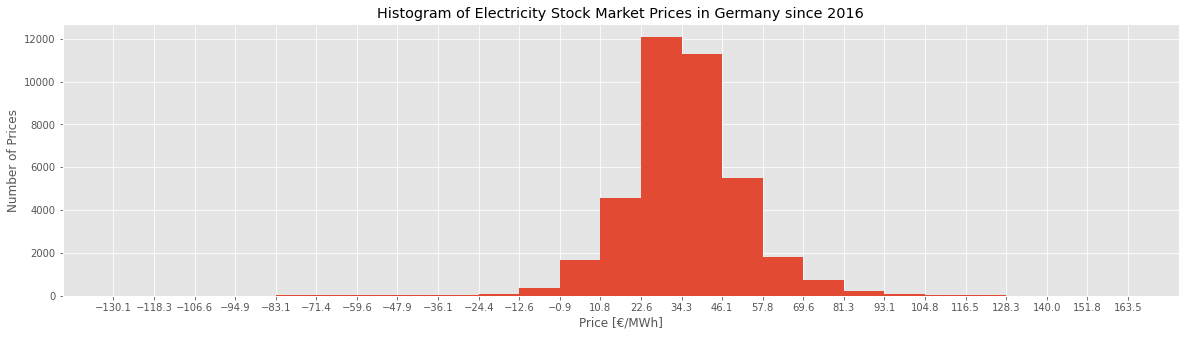

In [61]:
count, bin_edges = np.histogram(elec_sdp[ 'price[€/MWh]' ],bins=25)

print(count) # frequency count
print(bin_edges) # bin ranges, default = 10 bins

elec_sdp[ 'price[€/MWh]' ].plot(kind='hist', figsize=(20, 5), bins=25,xticks=bin_edges)

plt.title('Histogram of Electricity Stock Market Prices in Germany since 2016') # add a title to the histogram
plt.ylabel('Number of Prices') # add y-label
plt.xlabel('Price [€/MWh]') # add x-label

plt.show()

Furthermore we calculate the standard deviation, the skew and the kurtosis:

In [87]:
print('Standard deviation of the price distribution: ', elec_sdp[ 'price[€/MWh]' ].std())
print('Skew of the price distribution: ', elec_sdp[ 'price[€/MWh]' ].skew())
print('Kurtosis of the price distribution: ', elec_sdp[ 'price[€/MWh]' ].kurtosis())

Standard deviation of the price distribution:  17.285623762487205
Skew of the price distribution:  -0.3600558195870197
Kurtosis of the price distribution:  5.503093737706724


Seems that the price values are relative good normally distributed, but the price vector is very volatile.

Now we want to figure out the impact of the features on the price. Therefore, we create a correlation matrix:

In [66]:
elec_sdp.corr()

,Biomasse[MWh],Wasserkraft[MWh],Wind Offshore[MWh],Wind Onshore[MWh],Photovoltaik[MWh],Sonstige Erneuerbare[MWh],Kernenergie[MWh],Braunkohle[MWh],Steinkohle[MWh],Erdgas[MWh],Sonstige Konventionelle[MWh],Gesamt[MWh],price[€/MWh]
Biomasse[MWh],1.000000,-0.161062,0.257260,0.263409,-0.104105,0.465153,0.111806,-0.018420,0.056061,0.243752,-0.025482,0.112034,-0.010666
Wasserkraft[MWh],-0.161062,1.000000,-0.293893,-0.272504,0.207833,-0.346365,-0.091929,0.009219,-0.085411,-0.263733,-0.000812,-0.112499,-0.152870
Wind Offshore[MWh],0.257260,-0.293893,1.000000,0.677204,-0.141301,0.133658,-0.071207,-0.401991,-0.362326,0.064585,-0.262785,0.071688,-0.212894
Wind Onshore[MWh],0.263409,-0.272504,0.677204,1.000000,-0.181488,0.135274,-0.046084,-0.480681,-0.417544,-0.110412,-0.187684,0.100794,-0.398994
Photovoltaik[MWh],-0.104105,0.207833,-0.141301,-0.181488,1.000000,-0.156433,-0.202851,-0.120630,-0.077544,-0.044000,-0.088322,0.298470,-0.092240
Sonstige Erneuerbare[MWh],0.465153,-0.346365,0.133658,0.135274,-0.156433,1.000000,0.164044,0.267543,0.216529,0.136330,0.251001,0.240628,0.060311
Kernenergie[MWh],0.111806,-0.091929,-0.071207,-0.046084,-0.202851,0.164044,1.000000,0.427975,0.328495,0.075057,0.279384,0.165024,0.195976
Braunkohle[MWh],-0.018420,0.009219,-0.401991,-0.480681,-0.120630,0.267543,0.427975,1.000000,0.668761,0.094044,0.400051,0.306651,0.541161
Steinkohle[MWh],0.056061,-0.085411,-0.362326,-0.417544,-0.077544,0.216529,0.328495,0.668761,1.000000,0.354932,0.457105,0.560953,0.607215
Erdgas[MWh],0.243752,-0.263733,0.064585,-0.110412,-0.044000,0.136330,0.075057,0.094044,0.354932,1.000000,-0.298863,0.452862,0.557353


For easier interpretation we visualize the correlation matrix as a heatmap:

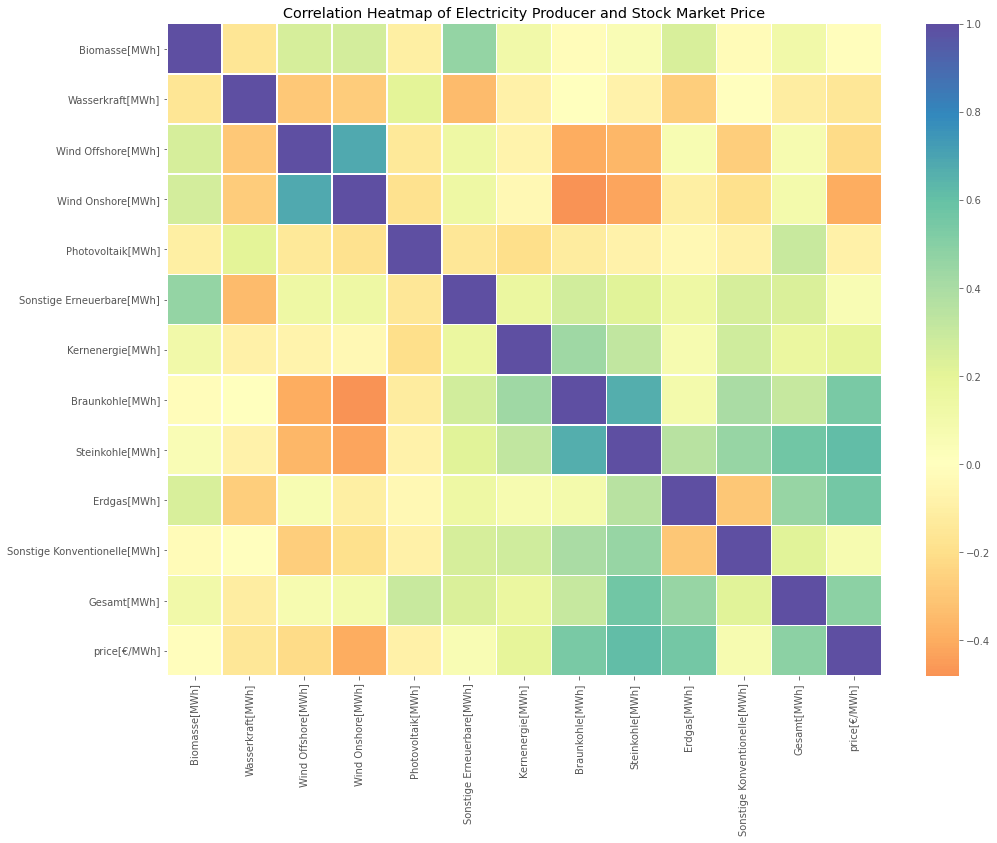

In [67]:
plt.figure(figsize=(16,12))
plt.title('Correlation Heatmap of Electricity Producer and Stock Market Price')
ax = sns.heatmap(elec_sdp.corr(),center=0,linewidths=.5,  cmap="Spectral")
plt.show()

In [0]:
elec_sdp.to_csv('elec_sdp',index=False)

## 3. Methodology <a name="methodology"></a>

In this section we describe the procedure for the analysis. 

Cause our business problem is an regression problem, we decide to use a multiple linear/ polynomial regression model and a LSTM neural network. We will try different hyperparameter to find the optimal setting.

As described in the business problem chapter, we try to make a prediction for the next timestep (1h). This we do with multiple regression. The 24h forecast we try with our neural network. Since the forecasts for the production and demand are quite accurate, we take the future production and demand as given and use them for our price prediction. To optimize the hyperparameter we will try many different constellations (but in this notebook you only find the best solutions).

As model performance indicator we choose the Root Mean Square. This is why, we want to punish outliers in the prediction, because outliers mean economic losses.

Before we start with modeling, we do some feature engineering based on the results of the correlation matrix to reduce the number of features and increase the performance.

## 4. Analysis <a name="analysis"></a>


First we install all necessary libaries for the Data Analysis:

In [0]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Next we load our data set:

In [0]:
elec_sdp=pd.read_csv('elec_sdp')

### 4.1 Feature Engineering:

Now we do some feature engineering. In regard to the determined correlations between the features, we can make following simplifications: As we can see biomass, hydropower, and the category other renewables has nearly the same correlation, we put them together to "Other renewables". We also combine Wind Off- and Onshore into Wind. Next we see that the fossil energy sources has also a nearly the same correlation. So we put them to "Fossil energy sources" together. Furthermore we can observe that the feature "Sonstige Konventionelle" ("Other fossils") has only little impact on the electricity stock market price, we decide to delete this feature.

In [0]:
elec_sdp['Other renewables[MWh]']=elec_sdp[['Biomasse[MWh]','Wasserkraft[MWh]','Sonstige Erneuerbare[MWh]']].sum(axis=1)
elec_sdp['Wind[MWh]']=elec_sdp[['Wind Offshore[MWh]','Wind Onshore[MWh]']].sum(axis=1)
elec_sdp['Fossil energy sources[MWh]']=elec_sdp[['Braunkohle[MWh]','Steinkohle[MWh]','Erdgas[MWh]']].sum(axis=1)
elec_sdp.drop(columns=['Sonstige Konventionelle[MWh]','Biomasse[MWh]','Wasserkraft[MWh]','Sonstige Erneuerbare[MWh]','Wind Offshore[MWh]','Wind Onshore[MWh]','Braunkohle[MWh]','Steinkohle[MWh]','Erdgas[MWh]'],inplace =True)

# Rearange the columns:
elec_sdp=elec_sdp[elec_sdp.columns[[0,1,-2,-3,-1,2,3,4]]]
# Rename the german in english columns:
elec_sdp.columns=['Datetime','Photovoltaics[MWh]', 'Wind[MWh]', 'Other renewables[MWh]', 'Fossil energy sources[MWh]', 'Nuclear Energy[MWh]','Total Consumption[MWh]', 'price[€/MWh]' ]

### 4.2 Train-, Test- Split

Define the input-dataset for the analysis:

In [0]:
input_data= elec_sdp.iloc[:,1:]

For the stateful LSTM approach, we have to ensure that the dataset can be divided by the batchsize:

In [0]:
batch_size = 64
timesteps = 24

In [0]:
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 200,int(length) ): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            #print(x)
    return (max(train_length_values))

def get_train_dataset(dataset,batch_size, test_percent,timesteps):
    train_length = get_train_length(dataset, batch_size, test_percent)
    upper_train = train_length + timesteps*2
    train_set = dataset[0:upper_train]
    return train_set, train_length, upper_train #X_train, X_test, y_train, y_test


def get_test_length(dataset, batch_size, upper_train, timesteps):
  test_length_values = []
  for x in range(len(dataset) - 200, len(dataset) - timesteps*2):
    modulo=(x-upper_train)%batch_size
    if (modulo == 0):
      test_length_values.append(x)
      #print(x)
  return (max(test_length_values))


def get_test_dataset(dataset,batch_size,upper_train, timesteps):
  test_length = get_test_length(dataset, batch_size, upper_train, timesteps)
  upper_test = test_length + timesteps*2
  test_set_length = test_length - upper_train
  test_set = dataset[upper_train:upper_test]
  return test_set, test_set_length

Get the train and test dataset:

In [22]:
train_set, train_length, upper_train = get_train_dataset(input_data,batch_size, 0.2,timesteps)
test_set, test_length = get_test_dataset(input_data,batch_size, upper_train, timesteps)

print(train_set.shape)
print(train_length)
print(test_set.shape)
print(test_length)

(30960, 7)
30912
(7664, 7)
7616


### 4.3 Multiple Polynomial/Linear Regression

In this section we try to predict the stock market electricity price for the next hour with a multiple linear or polynomial regression model.

First we have to import all necessary machine learning libaries:

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

Now we build the pipeline and train our model:

In [24]:
Input=[('scale',MinMaxScaler()), ('polynomial', PolynomialFeatures(include_bias=False, degree=2)), ('model',LinearRegression())]

#Input=[('scale',MinMaxScaler(feature_range = (-1, 1))),('model',LinearRegression())]

pipe=Pipeline(Input)

X_train_MLR = np.asanyarray(train_set.iloc[:,:-1])
y_train_MLR = np.asanyarray(train_set.iloc[:,-1:])

X_test_MLR = np.asanyarray(test_set.iloc[:,:-1])
y_test_MLR = np.asanyarray(test_set.iloc[:,-1:])

pipe.fit(X_train_MLR,y_train_MLR)

Pipeline(memory=None,
         steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('polynomial',
                 PolynomialFeatures(degree=2, include_bias=False,
                                    interaction_only=False, order='C')),
                ('model',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

Best results we get with a polynomial degree of 2. That means the linear regression model fits best.

In [0]:
y_predicted=pipe.predict(X_test_MLR)

Let's visualize the prediction results:

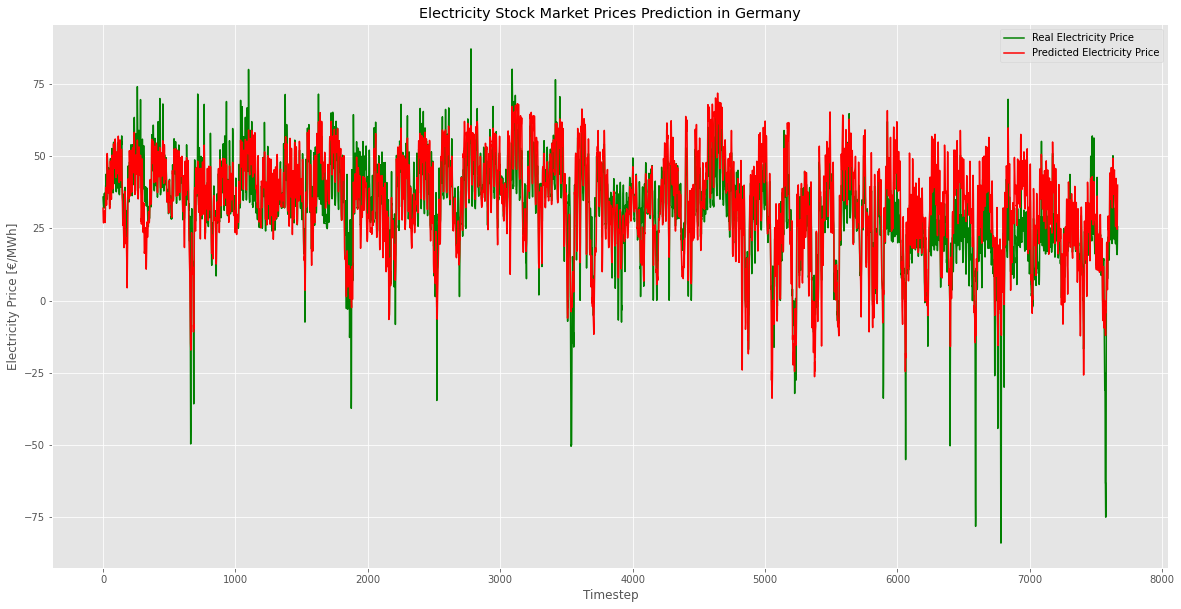

In [26]:
plt.figure(figsize=(20,10))
plt.plot(np.float64(test_set.iloc[0:len(y_predicted),-1]), color = 'green', label = 'Real Electricity Price')
plt.plot(y_predicted[0:len(y_predicted) ].astype(float), color = 'red', label = 'Predicted Electricity Price')
plt.title('Electricity Stock Market Prices Prediction in Germany')
plt.xlabel('Timestep')
plt.ylabel('Electricity Price [€/MWh]')
plt.legend()
plt.show()

That already looks pretty good.

**Judgment of the model results:**

Therefore we first define the mean price value as our baseline model:


In [0]:
mean = np.ones((len(y_predicted), 1)) * np.float64(test_set.iloc[0:len(y_predicted),-1]).mean()

1. RMSE (root mean squared error):


In [28]:
rmse_for_mean = math.sqrt(mean_squared_error(np.float64(test_set.iloc[0:len(y_predicted),-1]), mean ))
print(rmse_for_mean)

16.160473457421695


In [29]:
rmse = math.sqrt(mean_squared_error(np.float64(test_set.iloc[0:len(y_predicted),-1]), y_predicted ))
print(rmse)

9.405400131674975


2. MAE (mean absolute error):


In [30]:
mae = mean_absolute_error(np.float64(test_set.iloc[0:len(y_predicted),-1]), mean)
print(mae)

11.909698351782158


In [31]:
mae = mean_absolute_error(y_test_MLR,y_predicted)
print(mae)

6.9151125746224436


Thus our model is a better than our baseline model.

### 4.4 Neural Network - LSTM for 24h forecast

Feature Scaling for LSTM

In [0]:
# Feature Scaling
#scale between -1 and 1. the weights are esier to find.

mmsc_train = MinMaxScaler(feature_range = (-1, 1))
mmsc_test = MinMaxScaler(feature_range = (-1, 1))
mmsc_y_train = MinMaxScaler(feature_range = (-1, 1))
mmsc_y_test = MinMaxScaler(feature_range = (-1, 1))
train_set_scaled = mmsc_train.fit_transform(np.float64(train_set))
test_set_scaled = mmsc_test.fit_transform(np.float64(test_set))
y_train_set_scaled = mmsc_y_train.fit_transform(np.float64(train_set.iloc[:,-1:]))
y_test_set_scaled = mmsc_y_test.fit_transform(np.float64(test_set.iloc[:,-1:]))

Function for getting a training and test dataset for LSTM approach:

In [0]:
def create_datastructure_with_ts(dataset, length, timesteps,y_label_No):
  X=[]
  y=[]
  for i in range(0, length ):
    X.append(dataset[i:i+ timesteps,0:6])
    y.append(dataset[i:i+ timesteps, y_label_No])
    
  X, y= np.array(X), np.array(y)
  X = X.reshape(X.shape[0],timesteps, train_set.shape[1]-1)
  y = y.reshape(X.shape[0],timesteps, 1)

  return X,y

In [34]:
X_train_LSTM, y_train_LSTM = create_datastructure_with_ts(train_set_scaled, train_length, timesteps, y_label_No=-1)
X_test_LSTM, y_test_LSTM = create_datastructure_with_ts(test_set_scaled, test_length, timesteps, y_label_No=-1)
print(X_train_LSTM.shape)
print(X_test_LSTM.shape)
print(y_train_LSTM.shape)
print(y_test_LSTM.shape)

(30912, 24, 6)
(7616, 24, 6)
(30912, 24, 1)
(7616, 24, 1)


Now it is time to import Keras

In [35]:
from keras.preprocessing import sequence
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model
import h5py


Using TensorFlow backend.


Here is our LSTM neural network. Cause of the high resolution and volatility, we decide to use a deep network with many neurons. Furthermore we use the Adam Optimizer:

In [36]:
# Initialising the LSTM Model with MAE Loss-Function
# Using Functional API

inputs= Input(batch_shape=(batch_size,X_train_LSTM.shape[1],X_train_LSTM.shape[2]))
#each layer is the input of the next layer
lstm_1 = LSTM(100, stateful=True, return_sequences=True, dropout=0.2)(inputs)
lstm_2 = LSTM(60, stateful=True, return_sequences=True, dropout=0.2)(lstm_1)
dense_1 = Dense(units=512)(lstm_2)
dense_2 = Dense(units=256)(dense_1)
dense_3 = Dense(units=256)(dense_2)
dense_4 = Dense(units=64)(dense_3)
output = Dense(units = 1, activation='linear')(dense_4)

regressor = Model(inputs=inputs, outputs = output)

#adam is fast starting off and then gets slower and more precise
regressor.compile(optimizer='Adam', loss = 'mean_squared_error', metrics=['accuracy'])
regressor.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (64, 24, 6)               0         
_________________________________________________________________
lstm_1 (LSTM)                (64, 24, 100)             42800     
_________________________________________________________________
lstm_2 (LSTM)                (64, 24, 60)              38640     
_________________________________________________________________
dense_1 (Dense)              (64, 24, 512)             31232     
_________________________________________________________________
dense_2 (Dense)              (64, 24, 256)             131328    
_________________________________________________________________
dense_3 (Dense)              (64, 24, 256)             65792     
_________________________________________________________________
dense_4 (Dense)              (64, 24, 64)              1644

Now let' trian our model. Therefore we choose 60 iterations and a statefull approach.

In [38]:
epochs=75
#Statefull
for i in range(epochs):
    print("Epoch: " + str(i))
    #run through all data but the cell, hidden state are used for the next batch.
    regressor.fit(X_train_LSTM, y_train_LSTM, shuffle=False, epochs = 1, batch_size = batch_size)
    #resets only the states but the weights, cell and hidden are kept.
    regressor.reset_states()
    
#Stateless#
#between the batches the cell and hidden states are lost.
#regressor_mae.fit(X_train, y_train, shuffle=False, epochs = epochs, batch_size = batch_size)


Epoch: 0
Epoch 1/1
30912/30912 [==============================] - 47s 2ms/step - loss: 0.0055 - accuracy: 0.0000e+00
Epoch: 1
Epoch 1/1
30912/30912 [==============================] - 54s 2ms/step - loss: 0.0051 - accuracy: 0.0000e+00
Epoch: 2
Epoch 1/1
30912/30912 [==============================] - 49s 2ms/step - loss: 0.0050 - accuracy: 0.0000e+00
Epoch: 3
Epoch 1/1
30912/30912 [==============================] - 47s 2ms/step - loss: 0.0048 - accuracy: 1.0783e-05
Epoch: 4
Epoch 1/1
30912/30912 [==============================] - 48s 2ms/step - loss: 0.0048 - accuracy: 9.4354e-06
Epoch: 5
Epoch 1/1
30912/30912 [==============================] - 47s 2ms/step - loss: 0.0046 - accuracy: 1.3479e-05
Epoch: 6
Epoch 1/1
30912/30912 [==============================] - 47s 2ms/step - loss: 0.0045 - accuracy: 1.7523e-05
Epoch: 7
Epoch 1/1
30912/30912 [==============================] - 48s 2ms/step - loss: 0.0046 - accuracy: 2.6958e-06
Epoch: 8
Epoch 1/1
30912/30912 [==============================] 

In [0]:
#save model
regressor.save(filepath="my_model_multivariate_LSTM.h5")

In [0]:
#load model
#model = load_model("my_model_multivariate_LSTM2.h5")

Next step is to prediction with our test set.

In [40]:
#prediction
predicted_bcg_values_test = regressor.predict(X_test_LSTM, batch_size=batch_size)
regressor.reset_states()

print(predicted_bcg_values_test.shape)

#reshaping
predicted_bcg_values_test = np.reshape(predicted_bcg_values_test, 
                                       (predicted_bcg_values_test.shape[0], 
                                        predicted_bcg_values_test.shape[1]))

print(predicted_bcg_values_test.shape)

#inverse transform
predicted_bcg_values_test = mmsc_y_train.inverse_transform(predicted_bcg_values_test)

print(predicted_bcg_values_test.shape)

(7616, 24, 1)
(7616, 24)
(7616, 24)


In [41]:
#creating y_test data
y_test = []
for j in range(0, test_length - timesteps ):
    y_test = np.append(y_test, predicted_bcg_values_test[j, timesteps-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))
print(y_test.shape)

(7592, 1)


Visualising the results:

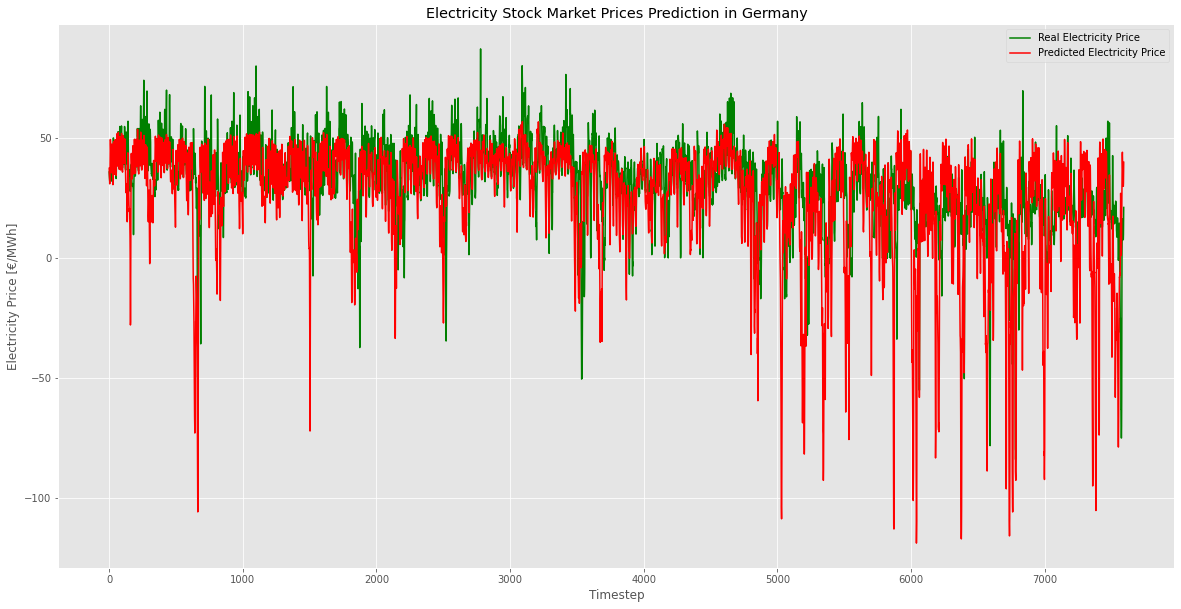

In [42]:
plt.figure(figsize=(20,10))
plt.plot(np.float64(test_set.iloc[0:len(y_test),-1]), color = 'green', label = 'Real Electricity Price')
plt.plot(y_test[0:len(y_test) ].astype(float), color = 'red', label = 'Predicted Electricity Price')
plt.title('Electricity Stock Market Prices Prediction in Germany')
plt.xlabel('Timestep')
plt.ylabel('Electricity Price [€/MWh]')
plt.legend()
plt.show()


Next we zoom in a smaller part of the graph. As we see the curve isn't already hit very well. As we have seen in the graph before there a lot outliers.

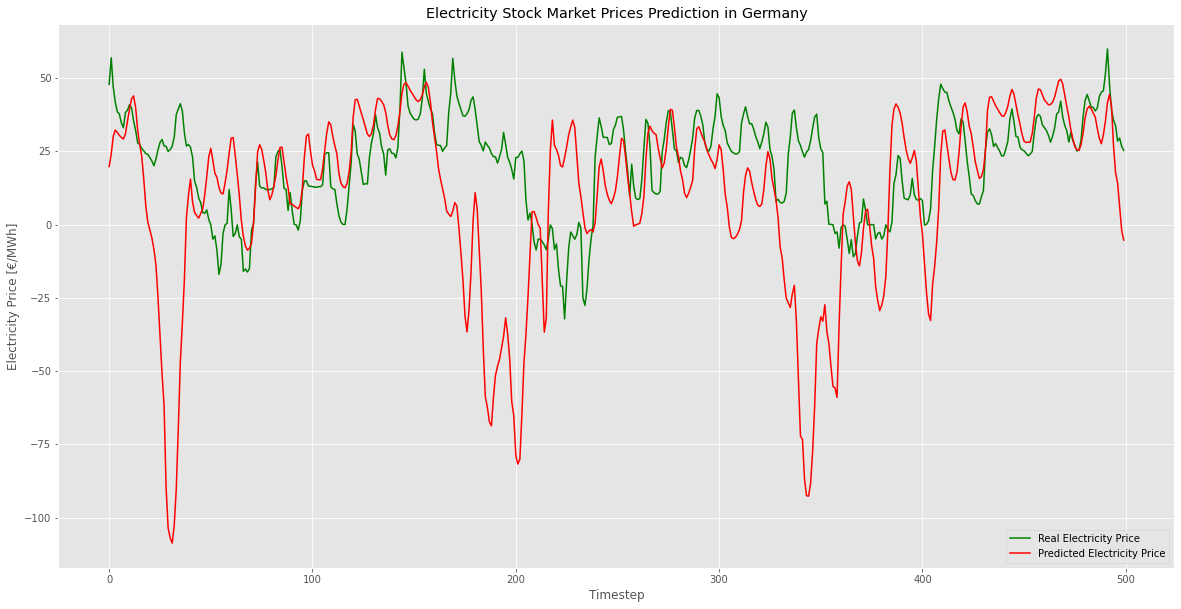

In [49]:
plt.figure(figsize=(20,10))
plt.plot(np.float64(test_set.iloc[5000:5500,-1]), color = 'green', label = 'Real Electricity Price')
plt.plot(y_test[5000:5500 ].astype(float), color = 'red', label = 'Predicted Electricity Price')
plt.title('Electricity Stock Market Prices Prediction in Germany')
plt.xlabel('Timestep')
plt.ylabel('Electricity Price [€/MWh]')
plt.legend()
plt.show()


**Judgment of the model results:**

Therefor we first use mean price baseline model like in the machine learning part:

In [0]:
mean = np.ones((len(y_test)-timesteps, 1)) * np.float64(test_set.iloc[timesteps:len(y_test),-1]).mean()

1. RMSE (root mean squared error):

In [45]:
rmse_for_mean = math.sqrt(mean_squared_error(np.float64(test_set.iloc[timesteps:len(y_test),-1]), mean ))
print(rmse_for_mean)

16.231698224380427


In [46]:
rmse = math.sqrt(mean_squared_error(np.float64(test_set.iloc[0:len(y_test),-1]),y_test))
print(rmse)

22.464068780463723


As we can already see the prediction of the model is quite bad, cause we would get a better overall result if we simply predict the mean value for every timestep!

2. MAE (mean absolute error):

In [47]:
mae_for_mean = mean_absolute_error(np.float64(test_set.iloc[timesteps:len(y_test),-1]), mean)
print(mae_for_mean)

11.956477790932333


In [48]:
mae = mean_absolute_error(np.float64(test_set.iloc[timesteps:len(y_test),-1]), y_test[0:len(y_test) - timesteps])
print(mae)

9.364146985065576


In regard to the MAE our model is a bit better than the baseline model.

**Fazit**:

Despite of many many attempts (increas/decrease depth, number of neurons, type of layers...) to get better prediction results, I didn't get better results than the baseline model. It seems as if the stock market prices are too volatile. Probably we would get better results if we consider the mean prices of every day, in order to decrease the resolution. But in that case a prediction would not have any business value.

### 4.5 Neural Network - LSTM for 1h forecast

Cause of the bad resulty for the 24h prediction of our neural network, we try a 1h forecast compareable to the linear regression.

In [0]:
timesteps2=1

Getting a training and test dataset for LSTM approach:

In [30]:
X_train_LSTM2, y_train_LSTM2 = create_datastructure_with_ts(train_set_scaled, train_length, timesteps2, y_label_No=-1)
X_test_LSTM2, y_test_LSTM2 = create_datastructure_with_ts(test_set_scaled, test_length, timesteps2, y_label_No=-1)
print(X_train_LSTM2.shape)
print(X_test_LSTM2.shape)
print(y_train_LSTM2.shape)
print(y_test_LSTM2.shape)

(30912, 1, 6)
(7616, 1, 6)
(30912, 1, 1)
(7616, 1, 1)


Here is our LSTM neural network. Cause of the high resolution and volatility, we decide to use a deep network with many neurons. Furthermore we use the Adam Optimizer:

In [35]:
# Initialising the LSTM Model with MAE Loss-Function
# Using Functional API

inputs= Input(batch_shape=(batch_size,X_train_LSTM2.shape[1],X_train_LSTM2.shape[2]))
#each layer is the input of the next layer
lstm_1 = LSTM(100, stateful=True, return_sequences=True, dropout=0.2)(inputs)
lstm_2 = LSTM(60, stateful=True, return_sequences=True, dropout=0.2)(lstm_1)
#lstm_3_mae = LSTM(15, stateful=True, return_sequences=True, dropout=0.15)(lstm_2_mae)
dense_1 = Dense(units=512)(lstm_2)
dense_2 = Dense(units=256)(dense_1)
dense_3 = Dense(units=256)(dense_2)
dense_4 = Dense(units=64)(dense_3)
output = Dense(units = 1, activation='linear')(dense_4)

regressor2 = Model(inputs=inputs, outputs = output)

#adam is fast starting off and then gets slower and more precise
#mae -> mean absolute error loss function
#regressor_mae.optimizer(optimizer='adam', opt)
regressor2.compile(optimizer='Adam', loss = 'mean_squared_error', metrics=['accuracy'])
regressor2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (64, 1, 6)                0         
_________________________________________________________________
lstm_3 (LSTM)                (64, 1, 100)              42800     
_________________________________________________________________
lstm_4 (LSTM)                (64, 1, 60)               38640     
_________________________________________________________________
dense_6 (Dense)              (64, 1, 512)              31232     
_________________________________________________________________
dense_7 (Dense)              (64, 1, 256)              131328    
_________________________________________________________________
dense_8 (Dense)              (64, 1, 256)              65792     
_________________________________________________________________
dense_9 (Dense)              (64, 1, 64)               1644

Now let' trian our model. Therefore we choose 60 iterations and a statefull approach.

In [37]:
epochs=60
#Statefull
for i in range(epochs):
    print("Epoch: " + str(i))
    #run through all data but the cell, hidden state are used for the next batch.
    regressor2.fit(X_train_LSTM2, y_train_LSTM2, shuffle=False, epochs = 1, batch_size = batch_size)
    #resets only the states but the weights, cell and hidden are kept.
    regressor2.reset_states()
    
#Stateless#
#between the batches the cell and hidden states are lost.
#regressor_mae.fit(X_train, y_train, shuffle=False, epochs = epochs, batch_size = batch_size)


Epoch: 0
Epoch 1/1
30912/30912 [==============================] - 6s 184us/step - loss: 0.0092 - accuracy: 0.0000e+00
Epoch: 1
Epoch 1/1
30912/30912 [==============================] - 5s 158us/step - loss: 0.0057 - accuracy: 0.0000e+00
Epoch: 2
Epoch 1/1
30912/30912 [==============================] - 5s 154us/step - loss: 0.0053 - accuracy: 0.0000e+00
Epoch: 3
Epoch 1/1
30912/30912 [==============================] - 5s 157us/step - loss: 0.0050 - accuracy: 0.0000e+00
Epoch: 4
Epoch 1/1
30912/30912 [==============================] - 5s 157us/step - loss: 0.0050 - accuracy: 0.0000e+00
Epoch: 5
Epoch 1/1
30912/30912 [==============================] - 5s 161us/step - loss: 0.0048 - accuracy: 0.0000e+00
Epoch: 6
Epoch 1/1
30912/30912 [==============================] - 5s 160us/step - loss: 0.0049 - accuracy: 0.0000e+00
Epoch: 7
Epoch 1/1
30912/30912 [==============================] - 5s 158us/step - loss: 0.0047 - accuracy: 0.0000e+00
Epoch: 8
Epoch 1/1
30912/30912 [========================

In [0]:
# Safe model
#regressor2.save(filepath="my_model_multivariate_LSTM22.h5")

In [0]:
#load model
#model = load_model("my_model_multivariate_LSTM2.h5")

Next step is to prediction with our test set.

In [85]:
#prediction
predicted_bcg_values_test2 = regressor2.predict(X_test_LSTM2, batch_size=batch_size)
regressor2.reset_states()

print(predicted_bcg_values_test2.shape)

#reshaping
predicted_bcg_values_test2 = np.reshape(predicted_bcg_values_test2, 
                                       (predicted_bcg_values_test2.shape[0], 
                                        predicted_bcg_values_test2.shape[1]))

print(predicted_bcg_values_test2.shape)

#inverse transform
predicted_bcg_values_test2 = mmsc_y_train.inverse_transform(predicted_bcg_values_test2)

print(predicted_bcg_values_test2.shape)

(7616, 1, 1)
(7616, 1)
(7616, 1)


In [0]:
#creating y_test data
y_test2 = predicted_bcg_values_test2

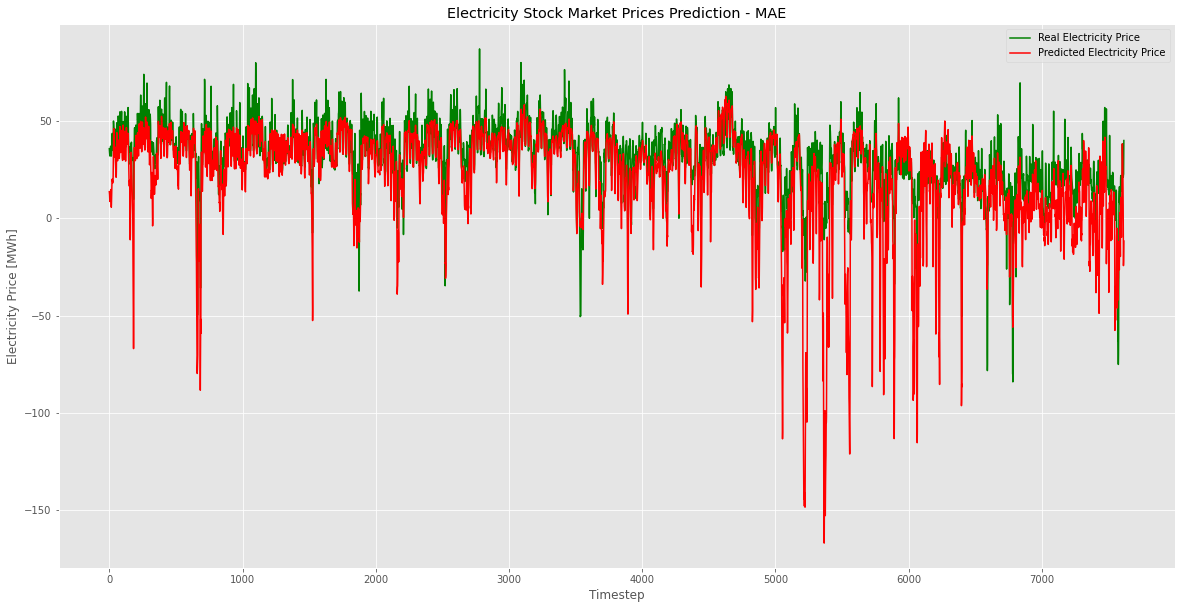

In [177]:
# Visualising the results
plt.figure(figsize=(20,10))
plt.plot(np.float64(test_set.iloc[0:len(y_test2),-1]), color = 'green', label = 'Real Electricity Price')
plt.plot(y_test2[0:len(y_test2) ].astype(float), color = 'red', label = 'Predicted Electricity Price')
plt.title('Electricity Stock Market Prices Prediction - MAE')
plt.xlabel('Timestep')
plt.ylabel('Electricity Price [MWh]')
plt.legend()
plt.show()

On the one hand the prediction curve looks not bad. But between timesteps 5000 and 6000 there are a lot outlier.

**Judgment of the model results:**

Therefore our baseline model is still the same

1. RMSE (root mean squared error):

In [88]:
rmse = math.sqrt(mean_squared_error(np.float64(test_set.iloc[0:len(y_test2),-1]),y_test2))
print(rmse)

19.21468921435897


2. MAE (mean absolute error):

In [93]:
mae = mean_absolute_error(np.float64(test_set.iloc[0:len(y_test2),-1]),y_test2)
print(mae)

11.07652160195485


**fazit:**

Even if the RMSE and MAE are little bit better than in the case before, the prediction is still worse than baseline model. Probably LSTM works better for longtime prediction to predict more than one day. 

## 5. Results and discussion <a name="results"></a>

As we have seen, the volatility of electricity exchange prices is very high at the given volatility. For this reason, the prediction approach using an LSTM neural network does not provide satisfactory results. It even gives worse results than our baseline model, which provides the mean value for each point in time. However, a further reduction of the time resolution does not make sense for the business case. 
The multilinear regression model, on the other hand, provides useful results for the 1h prediction.
